In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']
X.shape, y.shape # 784 features (28x28 pixels from 0 white to 255 black)

((70000, 784), (70000,))

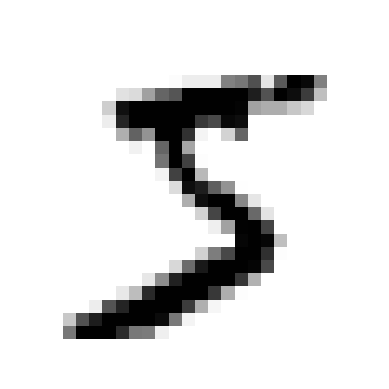

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

X = np.asarray(X)

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis('off')
plt.show()

In [4]:
y[0]

'5'

In [5]:
y = y.astype(np.uint8)

### split train and test (the mnist dataset is already shuffled)

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:] # train: frist 60000 images

### part 1: train a binary classifier (5-detector)

In [7]:
y_train_5 = (y_train == 5) # True or False
y_test_5 = (y_test == 5)

from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(random_state=42)
sgd.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [8]:
sgd.predict([some_digit])

array([ True])

### performance measures
1. CV score on accuracy (not good since only 10% are 5 can be easily guessed)

In [9]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [10]:
from sklearn.base import BaseEstimator

class Not5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)
    
not5 = Not5Classifier()
cross_val_score(not5, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

2. confusion matrix (CV prediction instead of score)

In [11]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd, X_train, y_train_5, cv=3)

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

TN = 53892, FP = 687
<br>FN = 1891, TP = 3539
<br>precision = TP/(TP+FP) = 3539/4226 = 83.7%
<br>recall = TP/(TP+FN) = 3539/5430 = 65.1%

In [12]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred)
# correct 83.7% of time, detect 65.1% of the 5s

(0.8370879772350012, 0.6511713705958311)

F1 = 2/(1/precision + 1/recall)
<br>= 2\*(precision \* recall)/(precision + recall)
<br>= TP/(TP + (FN + FP)/2)
<br>= 3539/(3539 + (1891 + 687)/2) = 73.3%
<br>F1 score is high only if both recall and precision are high

In [13]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [14]:
y_scores = sgd.decision_function([some_digit])
y_scores

array([2164.22030239])

In [15]:
threshold=0
y_some_digit_pred = (y_scores>threshold)
y_some_digit_pred

array([ True])

In [16]:
threshold = 8000
y_some_digit_pred = (y_scores>threshold)
y_some_digit_pred # raising the threshold decreases recall

array([False])

### decide which threshold to use

In [17]:
y_scores = cross_val_predict(sgd, X_train, y_train_5, cv=3, method='decision_function')
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

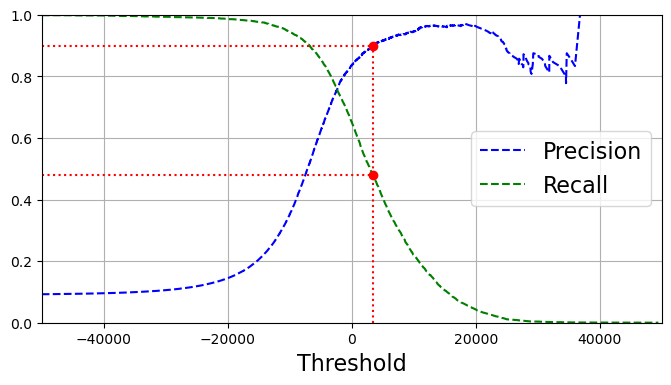

In [18]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label='Recall')
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])
    
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
# lines
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:") # top line                     # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:") # bottom line # Not shown
# dots
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
plt.show()

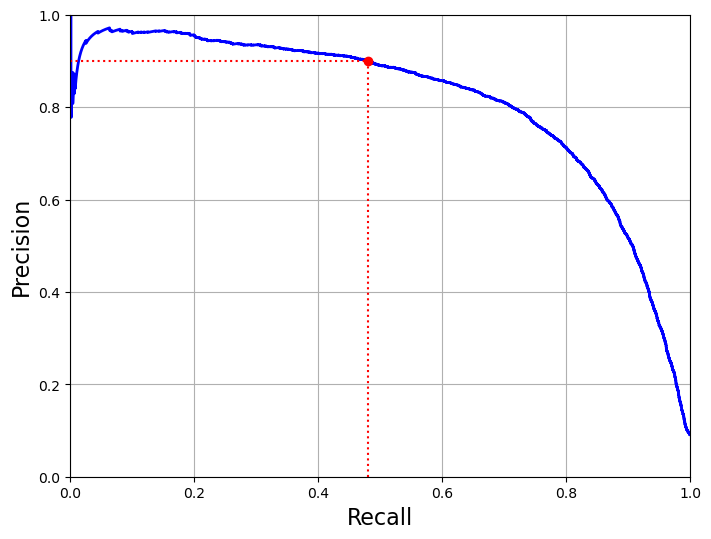

In [19]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:") # vertical line
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:") # horizontal line
plt.plot([recall_90_precision], [0.9], "ro") # dot
plt.show()

In [20]:
y_train_pred_90 = (y_scores>=threshold_90_precision)
print(threshold_90_precision)
precision_score(y_train_5, y_train_pred_90), recall_score(y_train_5, y_train_pred_90) # check precision and recall

3370.0194991439557


(0.9000345901072293, 0.4799852425751706)

### ROC curve (true positive rate (recall) vs false positive rate)
TPR = TP/(TP+FN) [recall/sensitivity]
<br>FPR = FP/(FP+TN) = 1 - TN/(FP+TN) = 1 - TNR [specificity]

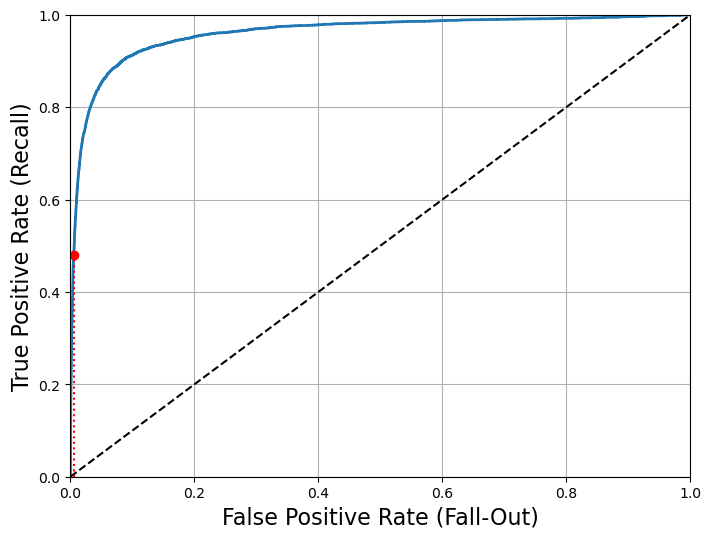

In [21]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:") # vertical line
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:") # horizontal line
plt.plot([fpr_90], [recall_90_precision], "ro") # dot
plt.show()

### compute AUC (area under curve)
perfect classifier has AUC=1, while purely random classifier has AUC=0.5

In [22]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

When consider FP (not5 classified as 5) more important than FN (5 classified as not5), use PR curve.
<br>When consider FN more important than FP, use ROC curve.
<br>Perfect PR curve should be at the top-right corner.
<br>Perfect ROC curve should be at the top-left corner.

### train random forest classifier

In [23]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
y_prob_rf = cross_val_predict(rf, X_train, y_train_5, cv=3, method='predict_proba')
y_prob_rf # row per instance and col per class, the probabiliyu of a given instance belongs to a given class

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

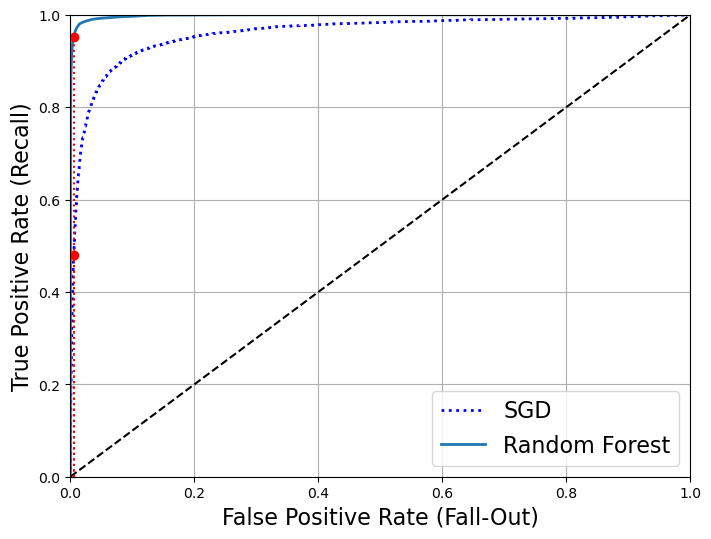

In [24]:
y_scores_rf = y_prob_rf[:,1] # probability of belonging to class 5
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_train_5, y_scores_rf)
recall_rf = tpr_rf[np.argmax(fpr_rf >= fpr_90)]

# draw compare plot
plt.figure(figsize=(8, 6))
# curves
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_rf, tpr_rf, "Random Forest")
# vertical lines
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([fpr_90, fpr_90], [0., recall_rf], "r:")
# horizontal line
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
# dots
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90], [recall_rf], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16) # since ROC curve is close to the top-left corner
plt.show()

In [25]:
roc_auc_score(y_train_5, y_scores_rf)

0.9983436731328145

In [26]:
y_train_pred_rf = cross_val_predict(rf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_rf), recall_score(y_train_5, y_train_pred_rf)

(0.9905083315756169, 0.8662608374838591)

### part 2: multiclass classification

In [27]:
sgd.fit(X_train, y_train) # full data, not y_train_5; OvA
sgd.predict([some_digit]) 

array([3], dtype=uint8)

In [28]:
some_digit_scores = sgd.decision_function([some_digit])
some_digit_scores # score for each class

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [29]:
np.argmax(some_digit_scores)

3

In [30]:
sgd.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [31]:
from sklearn.multiclass import OneVsOneClassifier

ovo = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo.fit(X_train, y_train)
ovo.predict([some_digit])

array([5], dtype=uint8)

In [32]:
len(ovo.estimators_)

45

In [33]:
rf.fit(X_train, y_train)
rf.predict([some_digit])

array([5], dtype=uint8)

In [34]:
rf.predict_proba([some_digit]) # the probabiliyu assigned to each instance for each class, 90% belongs to 5

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

In [35]:
cross_val_score(sgd, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [37]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd, X_train_scaled, y_train, cv=3, scoring='accuracy') # better after scaled

array([0.8983, 0.891 , 0.9018])

### error analysis

In [38]:
y_train_pred = cross_val_predict(sgd, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

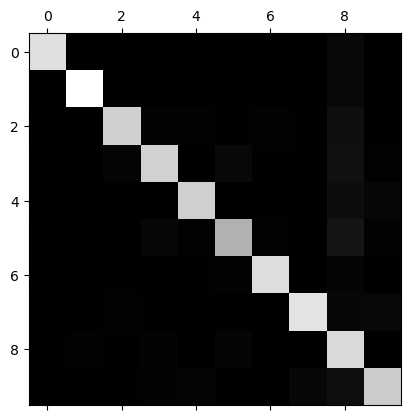

In [39]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show() # white means good, 5s look darker means not as good as others

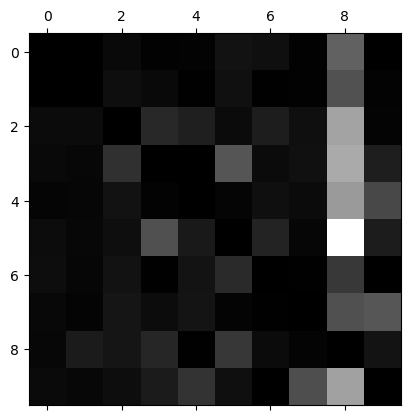

In [50]:
# error rate
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums

np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show() # row -> actul class, col -> predicted class
# the 8s is quite bright means many images were misclassed as 8

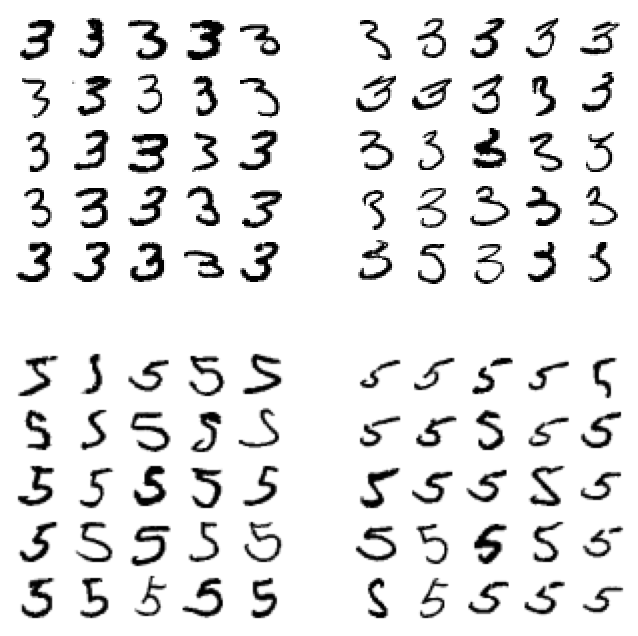

In [51]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1
    
    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size, images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

a, b = 3,5
X_aa = X_train[(y_train == a)&(y_train_pred == a)]
X_ab = X_train[(y_train == a)&(y_train_pred == b)] # 3 classified as 5
X_ba = X_train[(y_train == b)&(y_train_pred == a)] # 5 classified as 3
X_bb = X_train[(y_train == b)&(y_train_pred == b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()
# bottom-left: 5 classifies as 3
# top-right: 3 classified as 5

### multilabel classification

In [53]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn = KNeighborsClassifier()
knn.fit(X_train, y_multilabel)
knn.predict([some_digit]) # not large, odd

C:\Users\hejin\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


array([[False,  True]])

In [54]:
y_train_knn_pred = cross_val_predict(knn, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

C:\Users\hejin\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\hejin\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

0.976410265560605

### multioutput classification

In [56]:
# add noise to images
noise = np.random.randint(0,100,(len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100,(len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

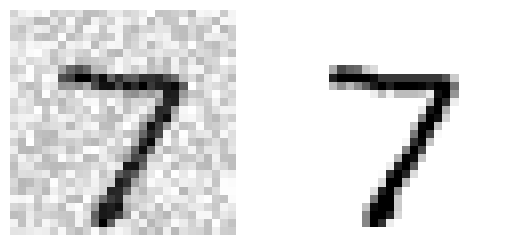

In [58]:
some_index = 0

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")
    
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

C:\Users\hejin\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


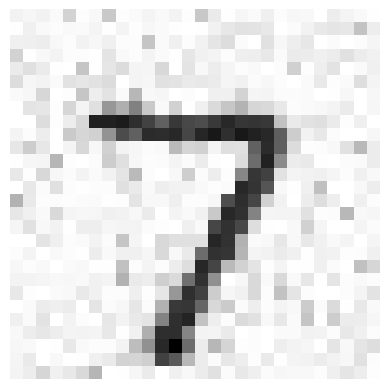

In [59]:
knn.fit(X_train, X_train_mod)
clean_digit = knn.predict([X_test_mod[some_index]])
plot_digit(clean_digit)